In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import seaborn as sns
import random
from copy import deepcopy

In [2]:
class CFG:
    height = 6
    width = 9
    start = [5, 3]
    goal  = [0, 8]
    action_Up = [-1, 0]
    action_Down = [1, 0]
    action_Left = [0, -1]
    action_Right = [0, 1]
    actions = [action_Up, action_Down, action_Left, action_Right]
    alpha = 1.0
    epsilon = 0.1
    max_step = 3000
    step_change = 1000
    n_run = 20
    n_plan = 5
    garma = 0.95

In [3]:
otc = [(3, 0),(3, 1),(3, 2),(3, 3),(3, 4),(3, 5), (3, 6),(3, 7)]
change_otc = [(3, 1),(3, 2),(3, 3),(3, 4),(3, 5), (3, 6),(3, 7), (3,8)]

def go(curX, curY, action, otc):
    [tmpX, tmpY] = CFG.actions[action]
    nextX = max(0, min(curX + tmpX, CFG.height - 1))
    nextY = max(0, min(curY + tmpY, CFG.width - 1))
    if ((nextX, nextY) in otc):
        (nextX, nextY) = (curX, curY)
    return (nextX, nextY)

def step(curX, curY, action, otc):
    (nextX, nextY) = go(curX, curY, action, otc)
    if ([nextX, nextY] == CFG.goal):
        return ([nextX, nextY], 1.0, True)
#     if ([nextX, nextY] == [curX, curY]):
#         return([nextX, nextY], -1, False)
    return ([nextX, nextY], 0.0, False)

In [4]:
def dyna_Q(n_plan, alpha = CFG.alpha, n_run = CFG.n_run, max_step = CFG.max_step):
    res = np.zeros((max_step+1))
    t_r = trange(n_run, desc = f'dynaQ n = {n_plan} a = {alpha}')
    for r in t_r:
        # Q = np.random.random((CFG.height, CFG.width, 4))
        time = 0
        Q = np.zeros(((CFG.height, CFG.width, 4)))
        model = {}
        while (time <= max_step):
            [curX, curY] = CFG.start
            while(True):
                    
                if(time>max_step):
                    break
                if (np.random.random()<CFG.epsilon):
                    action = np.random.choice(np.arange(4))
                else:
                    set_actions = Q[curX, curY,:] == np.max(Q[curX, curY, :])
                    actions = []
                    for i in range(4):
                        if (set_actions[i] == 1):
                            actions.append(i)
                    action = np.random.choice(actions)
                
                if (time >= CFG.step_change):
                    cur_otc = change_otc
                else:
                    cur_otc = otc
                (Nstate, reward, done) = step(curX, curY, action, cur_otc)
                res[time] += reward
                [nextX, nextY] = Nstate
#                 print(ep, (curX, curY), action, (nextX, nextY))
                Q[curX, curY, action] += alpha * (reward + CFG.garma * np.max(Q[nextX, nextY, :]) - Q[curX, curY, action])
                model[((curX, curY), action)] = ((nextX, nextY), reward)

                for _ in range(n_plan):
                    idx = np.random.choice(range(len(model.keys())))
                    ((tmpX, tmpY), tmp_action) = list(model.keys())[idx]
                    ((tmp_NX, tmp_NY), tmp_reward) = model[((tmpX, tmpY), tmp_action)]
                    Q[tmpX, tmpY, tmp_action] += alpha * (tmp_reward + CFG.garma * np.max(Q[tmp_NX, tmp_NY, :]) - Q[tmpX, tmpY, tmp_action])
                time += 1
                if (done):
                    break
                (curX, curY) = (nextX, nextY)
        t_r.set_description(f'dynaQ n = {n_plan} a = {alpha} res = {np.sum(res/(r+1)):.2f}')
            
    return np.add.accumulate(res/n_run)


In [5]:
def dyna_Q_plus(n_plan, alpha = CFG.alpha, n_run = CFG.n_run, max_step = CFG.max_step):
    res = np.zeros((max_step+1))
    t_r = trange(n_run, desc = f'dynaQ+ n = {n_plan} a = {alpha}')
    for r in t_r:
        # Q = np.random.random((CFG.height, CFG.width, 4))
        time = 0
#         Q = np.random.random(((CFG.height, CFG.width, 4)))
        Q = np.zeros((CFG.height, CFG.width, 4), dtype = float)
        model = {}
        while (time <= max_step):
            [curX, curY] = CFG.start
            while(True):
#                 print((curX, curY), Q[curX, curY,:])
                if(time>max_step):
                    break
                if (np.random.random()<CFG.epsilon):
                    action = np.random.choice(np.arange(4))
                else:
                    set_actions = Q[curX, curY,:] == np.max(Q[curX, curY, :])
                    actions = []
                    for i in range(4):
                        if (set_actions[i] == 1):
                            actions.append(i)
                    action = np.random.choice(actions)
                
                if (time >= CFG.step_change):
                    cur_otc = change_otc
                else:
                    cur_otc = otc
                (Nstate, reward, done) = step(curX, curY, action, cur_otc)
                res[time] += reward
                [nextX, nextY] = Nstate
#                 print(ep, (curX, curY), action, (nextX, nextY))
                Q[curX, curY, action] += alpha * (reward + CFG.garma * np.max(Q[nextX, nextY, :]) - Q[curX, curY, action])
                model[deepcopy(((curX, curY), action))] = deepcopy(((nextX, nextY), reward, time))
                for action_ in range(4):
                    if ((deepcopy(((curX, curY), action_))) not in model.keys()):
                        model[(deepcopy(((curX, curY), action_)))] = deepcopy(((nextX, nextY), 0, 0))

                for _ in range(n_plan):
                    idx = np.random.choice(range(len(model.keys())))
                    ((tmpX, tmpY), tmp_action) = list(model.keys())[idx]
                    ((tmp_NX, tmp_NY), tmp_reward, last_time) = model[((tmpX, tmpY), tmp_action)]
                    copy_reward = deepcopy(tmp_reward)
#                     print(f'--------{time}_{_}----------')
                    copy_reward += 0.001 * np.sqrt(time - last_time)
#                     print(Q[tmpX, tmpY, tmp_action])
#                     print((tmpX,tmpY),tmp_action,(tmp_NX, tmp_NY))
                    Q[tmpX, tmpY, tmp_action] += alpha * (copy_reward + CFG.garma * np.max(Q[tmp_NX, tmp_NY, :]) - Q[tmpX, tmpY, tmp_action])
#                     print(Q[tmpX, tmpY, tmp_action])
                time += 1
                if (done):
                    break
                (curX, curY) = (nextX, nextY)
        t_r.set_description(f'dynaQ+ n = {n_plan} a = {alpha} res = {np.sum(res/(r+1)):.2f}')
        
            
    return np.add.accumulate(res/n_run)


dynaQ n = 25 a = 1.0 res = 81.50: 100%|██████████| 20/20 [01:46<00:00,  5.31s/it]


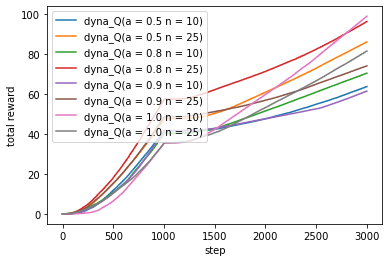

In [8]:
for alpha in [0.5, 0.8,0.9,1.0]:
    for n_plan in [10,25]:
        plt.plot(dyna_Q(n_plan = n_plan, alpha = alpha), label = f'dyna_Q(a = {alpha} n = {n_plan})')
#         plt.plot(dyna_Q_plus(n_plan = n_plan, alpha = alpha), label = f'dyna_Q+(a = {alpha} n = {n_plan})')

plt.xlabel('step')
plt.ylabel('total reward')
# plt.rcParams["figure.figsize"] = (40,40)
plt.legend()
plt.savefig('Ex8_2/figure_Ex8_2_dynaQ.png',dpi = 1200)
plt.show()

dynaQ+ n = 25 a = 1.0 res = 158.15: 100%|██████████| 20/20 [02:17<00:00,  6.87s/it]


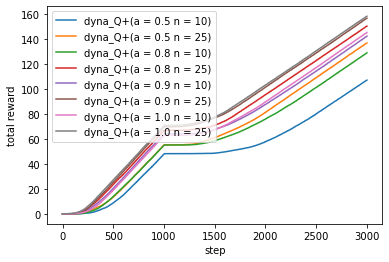

In [9]:
for alpha in [0.5, 0.8,0.9,1.0]:
    for n_plan in [10,25]:
#         plt.plot(dyna_Q(n_plan = n_plan, alpha = alpha),'--', label = f'dyna_Q(a = {alpha} n = {n_plan})')
        plt.plot(dyna_Q_plus(n_plan = n_plan, alpha = alpha), label = f'dyna_Q+(a = {alpha} n = {n_plan})')

plt.xlabel('step')
plt.ylabel('total reward')
# plt.rcParams["figure.figsize"] = (40,40)
plt.legend()
plt.savefig('Ex8_2/figure_Ex8_2_dynaQPlus.png',dpi = 1200)
plt.show()

dynaQ n = 25 a = 0.8 res = 81.40: 100%|██████████| 20/20 [01:55<00:00,  5.77s/it]


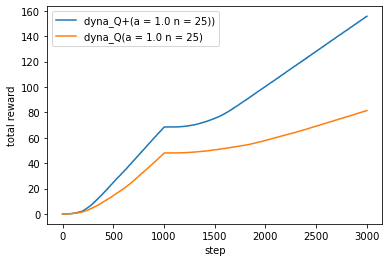

In [11]:
plt.plot(dyna_Q_plus(n_plan = 25, alpha = 1.0), label = f'dyna_Q+(a = {alpha} n = {n_plan}))')
plt.plot(dyna_Q(n_plan = 25, alpha = 0.8), label = f'dyna_Q(a = {alpha} n = {n_plan})')
plt.xlabel('step')
plt.ylabel('total reward')
# plt.rcParams["figure.figsize"] = (40,40)
plt.legend()
plt.savefig('Ex8_2/figure_Ex8_2.png')
plt.show()